In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import os
import sys
sys.path.insert(0, '../') # Hack to import from parent directory, to be removed
from tropical_cyclones import TCs
from aqua.util import load_yaml
from aqua.logger import log_configure
mainlogger = log_configure('INFO', log_name='MAIN')
from plotting_TCs import multi_plot, plot_trajectories

FDB5 binary library not present on system, disabling FDB support.


To run notebook with slurm

In [2]:
from aqua.slurm import slurm
slurm.job(cores=8, memory="50 GB", jobs=1, queue = "interactive", walltime='6:00:00')

2023-07-03 22:02:16 :: create_folder :: WARNING  -> Folder ./slurm already exists
2023-07-03 22:02:16 :: create_folder :: WARNING  -> Folder ./slurm/logs already exists
2023-07-03 22:02:16 :: create_folder :: WARNING  -> Folder ./slurm/output already exists
2023-07-03 22:02:20 :: slurm :: WARNING  -> #!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -p interactive
#SBATCH -A bb1153
#SBATCH -n 1
#SBATCH --cpus-per-task=8
#SBATCH --mem=47G
#SBATCH -t 6:00:00
#SBATCH --error=./slurm/logs/dask-worker-%j.err
#SBATCH --output=./slurm/output/dask-worker-%j.out

/work/bb1153/b382216/mambaforge/envs/TCs/bin/python -m distributed.cli.dask_worker tcp://136.172.124.6:38227 --nthreads 2 --nworkers 4 --memory-limit 11.64GiB --name dummy-name --nanny --death-timeout 60



Info on slurm job

In [3]:
slurm.squeue()

JOBID      CPUS  NODES ST         NAME                 TIME       START_TIME           DEPENDENCY           PARTITION            MIN_MEMORY          
5847323    24    1     R          dask-worker          0:10       2023-07-03T22:02:21  (null)               interactive          47G                 


0

Get variables and other parameters from configuration file and store them in a dictionary

In [2]:
# load the config file
tdict = load_yaml('../config/config.yml')
tdict

{'dataset': {'model': 'IFS', 'exp': 'tco1279-orca025-cycle3', 'source2d': '2D_1h_native', 'source3d': '3D_1h6h_native'}, 'paths': {'tmpdir': '/scratch/b/b382216/tmpdir', 'fulldir': '/scratch/b/b382216/fullres', 'plotdir': '/home/b/b382216/AQUA/AQUA/diagnostics/tropical_cyclones/Figures/'}, 'grids': {'lowgrid': 'r100', 'highgrid': 'r010'}, 'varlist': ['msl', '10u', '10v', 'tprate'], 'time': {'startdate': '2020-01-20', 'enddate': '2024-12-31', 'frequency': '6h'}, 'stream': {'streamstep': 10}, 'detect': {'boxdim': 10}, 'stitch': {'n_days_freq': 30, 'n_days_ext': 2}}

Initialises the TCs class and calls the loop_streaming method which is a wrapper to retrieve data, prepare them, run DetectNodes and StitchNodes
and finally save the selected variables (defined in the config.yml file) with original model resolution along TCs tracks in a netcdf file.

In [5]:
# initialise tropical class with streaming options
tropical = TCs(tdict=tdict, streaming=True, stream_step=tdict['stream']['streamstep'], stream_unit="days", 
               stream_startdate=tdict['time']['startdate'], loglevel = "WARNING")
tropical.loop_streaming(tdict)

2023-07-03 22:02:42 :: TCs :: WARNING  -> Initialised streaming for 10 days starting on 2020-04-09
2023-07-03 22:03:06 :: TCs :: WARNING  -> processing time step 20200409T00
2023-07-03 22:04:03 :: TCs :: WARNING  -> processing time step 20200409T06


KeyboardInterrupt: 

Plot some variables following a track for a few time steps

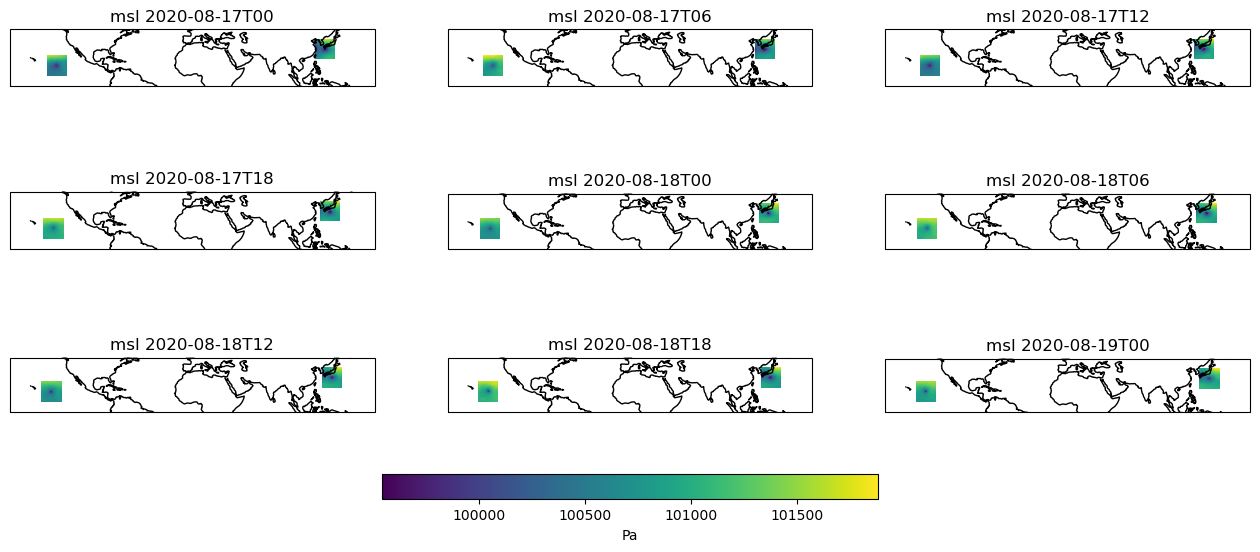

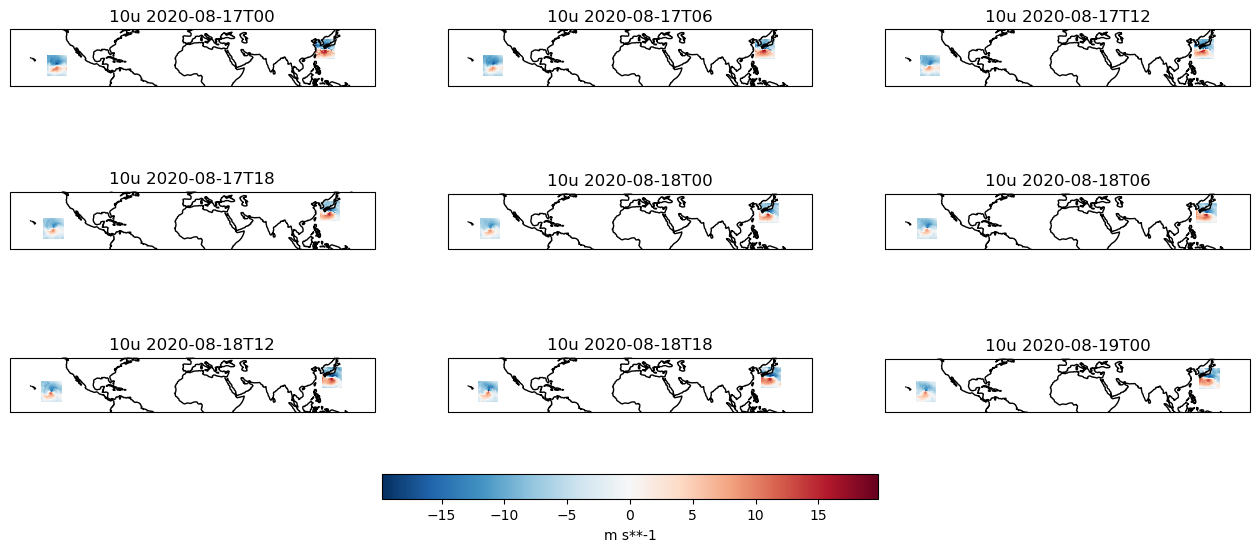

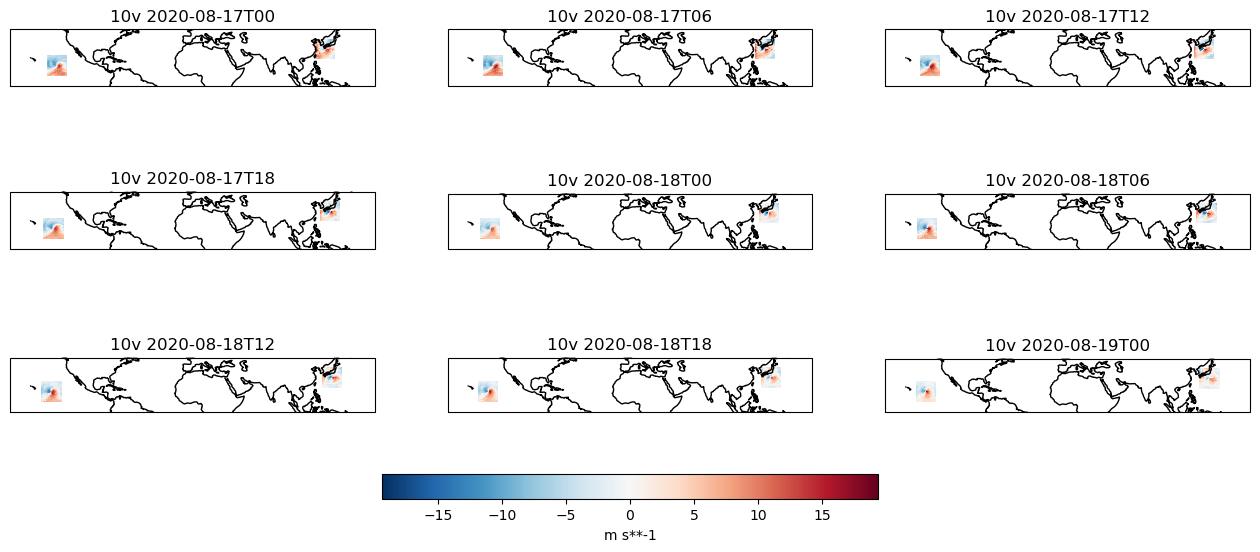

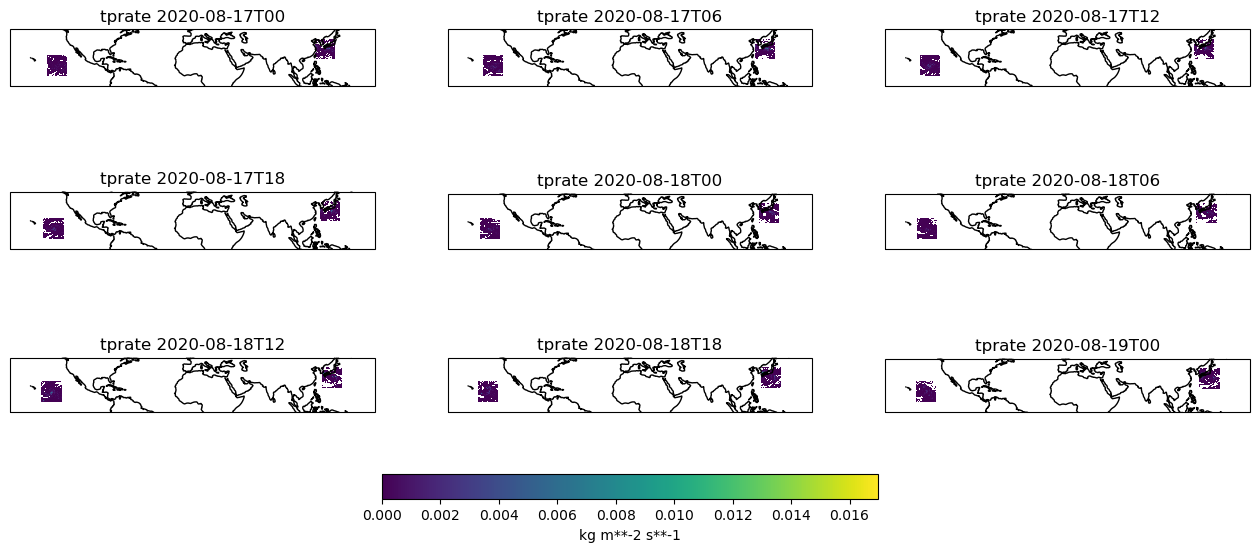

In [4]:
# at first select a track file to open. Tracks files are contained in the fulldir (see config file)

# select a start-end date for a period during which you want to plot variables

startend="20200817-20200915"
tracks_nc_file = os.path.join(tdict['paths']['fulldir'], tdict['dataset']['model'], tdict['dataset']['exp'], f"tempest_tracks_{startend}.nc")

# Example plot for variables contained in varlist:
for var in tdict['varlist']: 
    tracks_nc_file_var = xr.open_dataset(tracks_nc_file)[var]
    multi_plot(tracks_nc_file_var)

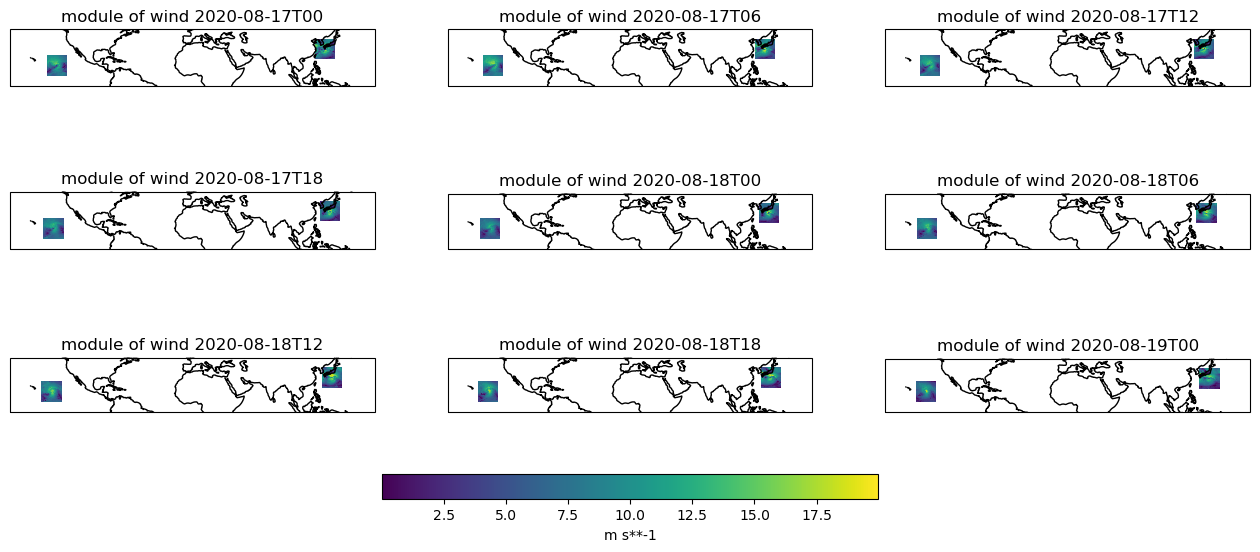

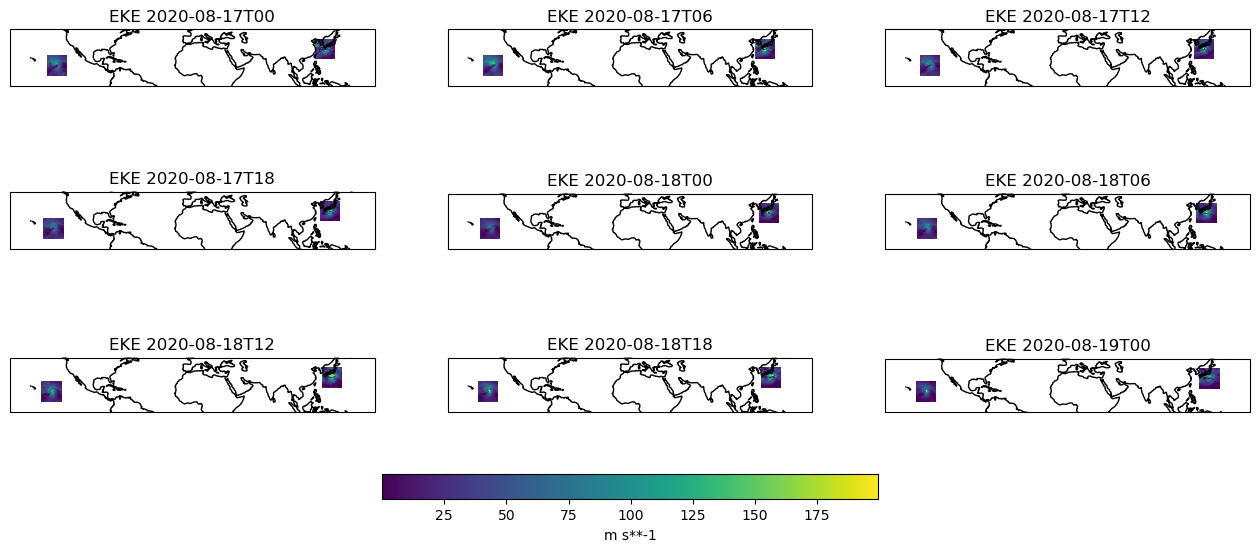

In [10]:
# at first select a track file to open. Tracks files are contained in the fulldir (see config file)

# select a start-end date for a period during which you want to plot variables

startend="20200817-20200915"
tracks_nc_file = os.path.join(tdict['paths']['fulldir'], tdict['dataset']['model'], tdict['dataset']['exp'], f"tempest_tracks_{startend}.nc")

# Example plot for module of wind and Eddy Kinetik Energy (EKE) (if 10u and 10v are available):

tracks_nc_file_u = xr.open_dataset(tracks_nc_file)["10u"]
tracks_nc_file_v = xr.open_dataset(tracks_nc_file)["10v"]

# module of wind
tracks_nc_file_uvmod = (tracks_nc_file_u**2 + tracks_nc_file_v**2)**0.5
multi_plot(tracks_nc_file_uvmod, title="module of wind", units="m/s")

# EKE
tracks_nc_file_EKE = 0.5*(tracks_nc_file_u**2 + tracks_nc_file_v**2)
multi_plot(tracks_nc_file_EKE, title="EKE", units="m**2/s**2")

Finally plot all TCs tracks found in the simulation

Getting trajectories from TempestExtremes file...
Running getTrajectories on '/scratch/b/b382216/tmpdir/IFS/tco1279-orca025-cycle3/tempest_tracks_tot.txt' with unstruc set to '0'
nVars set to 10 and headerDelimStr set to 'start'
Found 10 columns
Found 61 trajectories
... done reading data


/work/bb1153/b382216/mambaforge/envs/TCs/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/work/bb1153/b382216/mambaforge/envs/TCs/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '


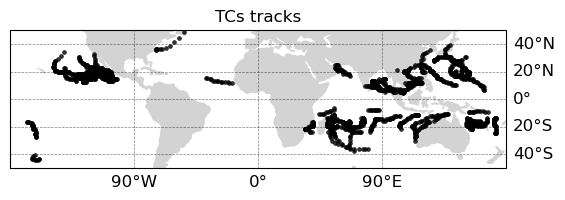

<Figure size 640x480 with 0 Axes>

In [3]:
from glob import glob

filenames = sorted(glob(os.path.join(tdict['paths']['tmpdir'], tdict['dataset']['model'], tdict['dataset']['exp'], "tempest_track*.txt")))

with open(os.path.join(tdict['paths']['tmpdir'], tdict['dataset']['model'], tdict['dataset']['exp'], f"tempest_tracks_tot.txt"), 'w') as output_file:
    for fname in filenames:
        with open(fname) as infile:
            for line in infile:
                output_file.write(line)
tracks_file = os.path.join(tdict['paths']['tmpdir'], tdict['dataset']['model'], tdict['dataset']['exp'], "tempest_tracks_tot.txt")
plot_trajectories(tracks_file, tdict['paths']['plotdir'])